# Web Voyager

[WebVoyager](https://arxiv.org/abs/2401.13919) by He, et. al., is a vision-enabled web-browsing agent capable of controlling the mouse and keyboard.

It works by viewing annotated browser screenshots for each turn, then choosing the next step to take. The agent architecture is a basic reasoning and action (ReAct) loop. 
The unique aspects of this agent are:
- It's usage of [Set-of-Marks](https://som-gpt4v.github.io/)-like image annotations to serve as UI affordances for the agent
- It's application in the browser by using tools to control both the mouse and keyboard

The overall design looks like the following:

<!-- ![Voyager Image](./img/web-voyager.excalidraw.png) -->
<img src="./img/web-voyager.excalidraw.png" width="50%">


## Setup

First, let's install our required packages:

In [ ]:
%%capture --no-stderr
%pip install -U --quiet langgraph langsmith langchain_openai

In [2]:
import os
from getpass import getpass


def _getpass(env_var: str):
    if not os.environ.get(env_var):
        os.environ[env_var] = getpass(f"{env_var}=")


_getpass("OPENAI_API_KEY")

<div class="admonition tip">
    <p class="admonition-title">Setup <a href="https://smith.langchain.com">LangSmith</a> for LangGraph development</p>
    <p style="padding-top: 5px;">
        Sign up for LangSmith to quickly spot issues and improve the performance of your LangGraph projects. LangSmith lets you use trace data to debug, test, and monitor your LLM apps built with LangGraph — read more about how LangSmith can help you <a href="https://docs.smith.langchain.com
        ">here</a>. 
    </p>
</div>    

#### Install Agent requirements

The only additional requirement we have is the [playwright](https://playwright.dev/) browser. Uncomment and install below:

In [3]:
# %pip install --upgrade --quiet  playwright > /dev/null
# !playwright install

In [4]:
import nest_asyncio

# This is just required for running async playwright in a Jupyter notebook
nest_asyncio.apply()

## Define graph

### Define graph state

The state provides the inputs to each node in the graph.

In our case, the agent will track the webpage object (within the browser), annotated images + bounding boxes, the user's initial request, and the messages containing the agent scratchpad, system prompt, and other information.


In [5]:
from typing import List, Optional, TypedDict

from langchain_core.messages import BaseMessage, SystemMessage
from playwright.async_api import Page


class BBox(TypedDict):
    x: float
    y: float
    text: str
    type: str
    ariaLabel: str


class Prediction(TypedDict):
    action: str
    args: Optional[List[str]]


# This represents the state of the agent
# as it proceeds through execution
class AgentState(TypedDict):
    page: Page  # The Playwright web page lets us interact with the web environment
    input: str  # User request
    img: str  # b64 encoded screenshot
    bboxes: List[BBox]  # The bounding boxes from the browser annotation function
    prediction: Prediction  # The Agent's output
    # A system message (or messages) containing the intermediate steps
    scratchpad: List[BaseMessage]
    observation: str  # The most recent response from a tool

### Define tools

The agent has 6 simple tools:

1. Click (at labeled box)
2. Type
3. Scroll
4. Wait
5. Go back
6. Go to search engine (Google)


We define them below here as functions:

In [6]:
import asyncio
import platform


async def click(state: AgentState):
    # - Click [Numerical_Label]
    page = state["page"]
    click_args = state["prediction"]["args"]
    if click_args is None or len(click_args) != 1:
        return f"Failed to click bounding box labeled as number {click_args}"
    bbox_id = click_args[0]
    bbox_id = int(bbox_id)
    try:
        bbox = state["bboxes"][bbox_id]
    except Exception:
        return f"Error: no bbox for : {bbox_id}"
    x, y = bbox["x"], bbox["y"]
    await page.mouse.click(x, y)
    # TODO: In the paper, they automatically parse any downloaded PDFs
    # We could add something similar here as well and generally
    # improve response format.
    return f"Clicked {bbox_id}"


async def type_text(state: AgentState):
    page = state["page"]
    type_args = state["prediction"]["args"]
    if type_args is None or len(type_args) != 2:
        return (
            f"Failed to type in element from bounding box labeled as number {type_args}"
        )
    bbox_id = type_args[0]
    bbox_id = int(bbox_id)
    bbox = state["bboxes"][bbox_id]
    x, y = bbox["x"], bbox["y"]
    text_content = type_args[1]
    await page.mouse.click(x, y)
    # Check if MacOS
    select_all = "Meta+A" if platform.system() == "Darwin" else "Control+A"
    await page.keyboard.press(select_all)
    await page.keyboard.press("Backspace")
    await page.keyboard.type(text_content)
    await page.keyboard.press("Enter")
    return f"Typed {text_content} and submitted"


async def scroll(state: AgentState):
    page = state["page"]
    scroll_args = state["prediction"]["args"]
    if scroll_args is None or len(scroll_args) != 2:
        return "Failed to scroll due to incorrect arguments."

    target, direction = scroll_args

    if target.upper() == "WINDOW":
        # Not sure the best value for this:
        scroll_amount = 500
        scroll_direction = (
            -scroll_amount if direction.lower() == "up" else scroll_amount
        )
        await page.evaluate(f"window.scrollBy(0, {scroll_direction})")
    else:
        # Scrolling within a specific element
        scroll_amount = 200
        target_id = int(target)
        bbox = state["bboxes"][target_id]
        x, y = bbox["x"], bbox["y"]
        scroll_direction = (
            -scroll_amount if direction.lower() == "up" else scroll_amount
        )
        await page.mouse.move(x, y)
        await page.mouse.wheel(0, scroll_direction)

    return f"Scrolled {direction} in {'window' if target.upper() == 'WINDOW' else 'element'}"


async def wait(state: AgentState):
    sleep_time = 5
    await asyncio.sleep(sleep_time)
    return f"Waited for {sleep_time}s."


async def go_back(state: AgentState):
    page = state["page"]
    await page.go_back()
    return f"Navigated back a page to {page.url}."


async def to_google(state: AgentState):
    page = state["page"]
    await page.goto("https://www.google.com/")
    return "Navigated to google.com."

### Define Agent

The agent is driven by a multi-modal model and decides the action to take for each step. It is composed of a few runnable objects:

1. A `mark_page` function to annotate the current page with bounding boxes
2. A prompt to hold the user question, annotated image, and agent scratchpad
3. GPT-4V to decide the next steps
4. Parsing logic to extract the action


Let's first define the annotation step:
#### Browser Annotations

This function annotates all buttons, inputs, text areas, etc. with numbered bounding boxes. GPT-4V then just has to refer to a bounding box
when taking actions, reducing the complexity of the overall task.

In [7]:
import base64

from langchain_core.runnables import chain as chain_decorator

# Some javascript we will run on each step
# to take a screenshot of the page, select the
# elements to annotate, and add bounding boxes
with open("mark_page.js") as f:
    mark_page_script = f.read()


@chain_decorator
async def mark_page(page):
    await page.evaluate(mark_page_script)
    for _ in range(10):
        try:
            bboxes = await page.evaluate("markPage()")
            break
        except Exception:
            # May be loading...
            asyncio.sleep(3)
    screenshot = await page.screenshot()
    # Ensure the bboxes don't follow us around
    await page.evaluate("unmarkPage()")
    return {
        "img": base64.b64encode(screenshot).decode(),
        "bboxes": bboxes,
    }

#### Agent definition

Now we'll compose this function with the prompt, llm and output parser to complete our agent.

In [8]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_openai import ChatOpenAI


async def annotate(state):
    marked_page = await mark_page.with_retry().ainvoke(state["page"])
    return {**state, **marked_page}


def format_descriptions(state):
    labels = []
    for i, bbox in enumerate(state["bboxes"]):
        text = bbox.get("ariaLabel") or ""
        if not text.strip():
            text = bbox["text"]
        el_type = bbox.get("type")
        labels.append(f'{i} (<{el_type}/>): "{text}"')
    bbox_descriptions = "\nValid Bounding Boxes:\n" + "\n".join(labels)
    return {**state, "bbox_descriptions": bbox_descriptions}


def parse(text: str) -> dict:
    action_prefix = "Action: "
    if not text.strip().split("\n")[-1].startswith(action_prefix):
        return {"action": "retry", "args": f"Could not parse LLM Output: {text}"}
    action_block = text.strip().split("\n")[-1]

    action_str = action_block[len(action_prefix) :]
    split_output = action_str.split(" ", 1)
    if len(split_output) == 1:
        action, action_input = split_output[0], None
    else:
        action, action_input = split_output
    action = action.strip()
    if action_input is not None:
        action_input = [
            inp.strip().strip("[]") for inp in action_input.strip().split(";")
        ]
    return {"action": action, "args": action_input}


# Will need a later version of langchain to pull
# this image prompt template
prompt = hub.pull("wfh/web-voyager")

In [9]:
llm = ChatOpenAI(model="gpt-4-vision-preview", max_tokens=4096)
agent = annotate | RunnablePassthrough.assign(
    prediction=format_descriptions | prompt | llm | StrOutputParser() | parse
)

## Compile the graph

We've created most of the important logic. We have one more function to define that will help us update the graph state after a tool is called.

In [10]:
import re


def update_scratchpad(state: AgentState):
    """After a tool is invoked, we want to update
    the scratchpad so the agent is aware of its previous steps"""
    old = state.get("scratchpad")
    if old:
        txt = old[0].content
        last_line = txt.rsplit("\n", 1)[-1]
        step = int(re.match(r"\d+", last_line).group()) + 1
    else:
        txt = "Previous action observations:\n"
        step = 1
    txt += f"\n{step}. {state['observation']}"

    return {**state, "scratchpad": [SystemMessage(content=txt)]}

Now we can compose everything into a graph:

In [11]:
from langchain_core.runnables import RunnableLambda

from langgraph.graph import END, START, StateGraph

graph_builder = StateGraph(AgentState)


graph_builder.add_node("agent", agent)
graph_builder.add_edge(START, "agent")

graph_builder.add_node("update_scratchpad", update_scratchpad)
graph_builder.add_edge("update_scratchpad", "agent")

tools = {
    "Click": click,
    "Type": type_text,
    "Scroll": scroll,
    "Wait": wait,
    "GoBack": go_back,
    "Google": to_google,
}


for node_name, tool in tools.items():
    graph_builder.add_node(
        node_name,
        # The lambda ensures the function's string output is mapped to the "observation"
        # key in the AgentState
        RunnableLambda(tool) | (lambda observation: {"observation": observation}),
    )
    # Always return to the agent (by means of the update-scratchpad node)
    graph_builder.add_edge(node_name, "update_scratchpad")


def select_tool(state: AgentState):
    # Any time the agent completes, this function
    # is called to route the output to a tool or
    # to the end user.
    action = state["prediction"]["action"]
    if action == "ANSWER":
        return END
    if action == "retry":
        return "agent"
    return action


graph_builder.add_conditional_edges("agent", select_tool)

graph = graph_builder.compile()

## Use the graph

Now that we've created the whole agent executor, we can run it on a few questions! We'll start our browser at "google.com" and then let it control the rest.

Below is a helper function to help print out the steps to the notebook (and display the intermediate screenshots).

In [12]:
from IPython import display
from playwright.async_api import async_playwright

browser = await async_playwright().start()
# We will set headless=False so we can watch the agent navigate the web.
browser = await browser.chromium.launch(headless=False, args=None)
page = await browser.new_page()
_ = await page.goto("https://www.google.com")


async def call_agent(question: str, page, max_steps: int = 150):
    event_stream = graph.astream(
        {
            "page": page,
            "input": question,
            "scratchpad": [],
        },
        {
            "recursion_limit": max_steps,
        },
    )
    final_answer = None
    steps = []
    async for event in event_stream:
        # We'll display an event stream here
        if "agent" not in event:
            continue
        pred = event["agent"].get("prediction") or {}
        action = pred.get("action")
        action_input = pred.get("args")
        display.clear_output(wait=False)
        steps.append(f"{len(steps) + 1}. {action}: {action_input}")
        print("\n".join(steps))
        display.display(display.Image(base64.b64decode(event["agent"]["img"])))
        if "ANSWER" in action:
            final_answer = action_input[0]
            break
    return final_answer

1. Type: ['7', 'WebVoyager paper arXiv']
2. Click: ['32']
3. Click: ['3']
4. ANSWER;: ['The "WebVoyager" paper discusses the development of an end-to-end web agent that leverages large multimodal models. The abstract highlights the importance of such agents in automating complex tasks on the web, which remains a challenging domain due to the heterogeneity in structure and the semantic gap between humans and machines. The paper proposes a solution that combines neural symbolic models and multimodal web environments, aiming to advance the capabilities of these agents to perform web browsing tasks effectively. Further details would require a more in-depth analysis of the paper\'s content beyond the abstract.']


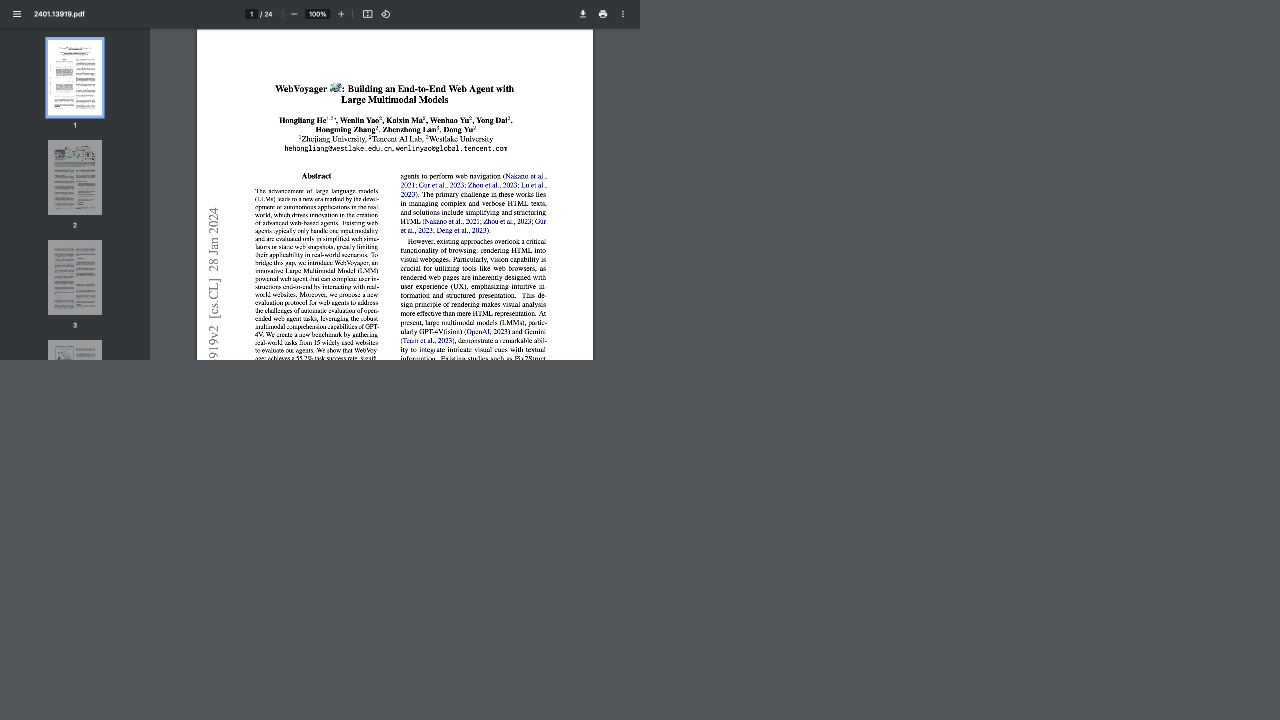

Final response: The "WebVoyager" paper discusses the development of an end-to-end web agent that leverages large multimodal models. The abstract highlights the importance of such agents in automating complex tasks on the web, which remains a challenging domain due to the heterogeneity in structure and the semantic gap between humans and machines. The paper proposes a solution that combines neural symbolic models and multimodal web environments, aiming to advance the capabilities of these agents to perform web browsing tasks effectively. Further details would require a more in-depth analysis of the paper's content beyond the abstract.


In [13]:
res = await call_agent("Could you explain the WebVoyager paper (on arxiv)?", page)
print(f"Final response: {res}")

1. retry: Could not parse LLM Output: I'm sorry, but the image provided does not contain an XKCD comic. The image shows a page from a scientific paper titled "WebVoyager 2: Building an End-to-End Web Agent with Large Multimodal Models." If you provide the XKCD comic you're referring to, I'd be happy to explain the humor in it.
2. retry: Could not parse LLM Output: I'm sorry, but I cannot assist with that request.
3. Google: None
4. Type: ['6', 'xkcd.com']
5. Click: ['25']
6. ANSWER;: ['The XKCD comic titled "Relationship Advice" pokes fun at the sometimes exaggerated way people talk about the challenges of relationships. It starts with one character stating that relationships require constant work and are like a job, which is a common sentiment. However, the other character takes this comparison to an extreme, calling it a "grueling ordeal" and a "crushing burden," which humorously exaggerates the difficulties of maintaining a relationship. The punchline comes when, after this escalati

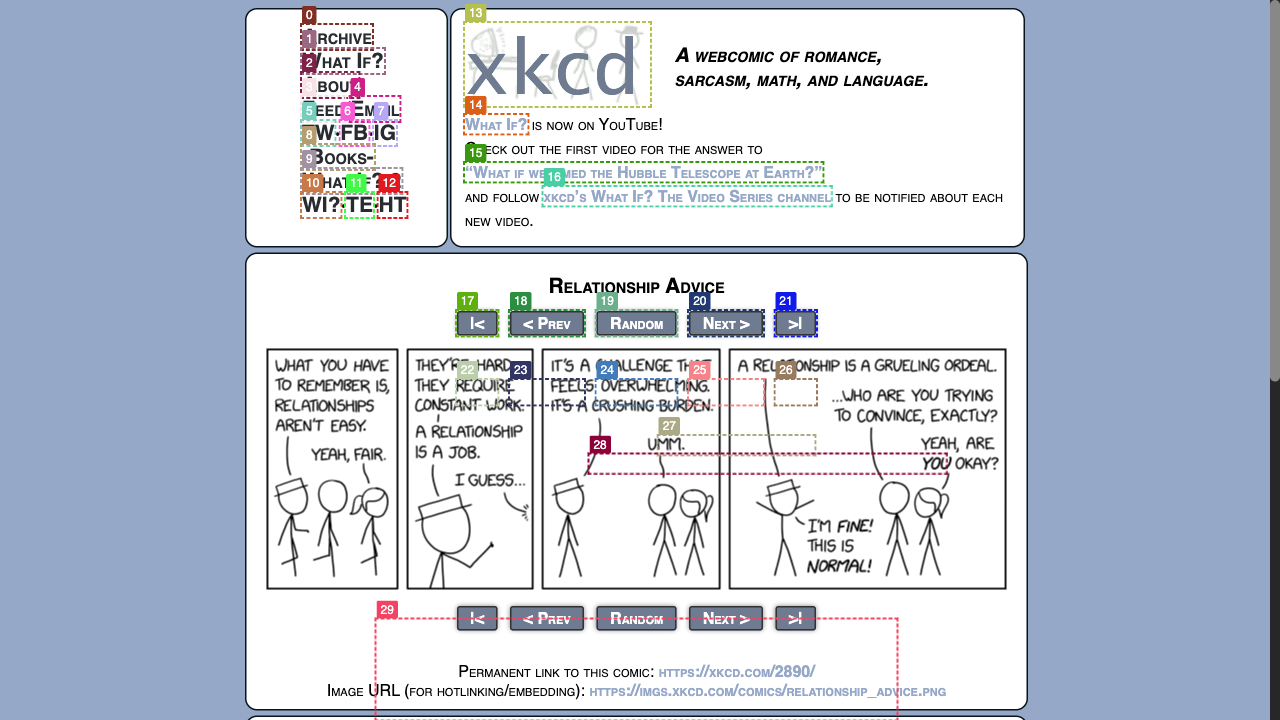

Final response: The XKCD comic titled "Relationship Advice" pokes fun at the sometimes exaggerated way people talk about the challenges of relationships. It starts with one character stating that relationships require constant work and are like a job, which is a common sentiment. However, the other character takes this comparison to an extreme, calling it a "grueling ordeal" and a "crushing burden," which humorously exaggerates the difficulties of maintaining a relationship. The punchline comes when, after this escalation, the second character insists they're fine and that it's all normal, which satirizes how people might downplay their struggles to appear in control or deny the extent of their challenges. The humor lies in the hyperbole and the relatable nature of discussing relationship difficulties, as well as the contrast between the characters' statements and the insistence that everything is okay.


In [14]:
res = await call_agent(
    "Please explain the today's XKCD comic for me. Why is it funny?", page
)
print(f"Final response: {res}")

In [15]:
res = await call_agent("What are the latest blog posts from langchain?", page)
print(f"Final response: {res}")

1. Google: None
2. Type: ['6', 'latest blog posts from langchain']
3. Click: ['27']
4. Click: ['14']
5. Click: ['0']
6. retry: Could not parse LLM Output: Thought: The latest blog posts from Langchain are displayed on the right side of the screen with titles and reading time. I will provide the titles of the featured blog posts as seen on the screen.

Action: ANSWER; The latest blog posts from Langchain are:
1. OpenGPTs - 7 min read
2. LangGraph: Multi-Agent Workflows - 6 min read
3. LangGraph - 7 min read
4. LangChain v0.1.0 - 10 min read
7. ANSWER;: ['The latest blog posts from Langchain are "OpenGPTs," "LangGraph: Multi-Agent Workflows," and "LangGraph."']


Final response: The latest blog posts from Langchain are "OpenGPTs," "LangGraph: Multi-Agent Workflows," and "LangGraph."


1. Google: None
2. Type: ['6', 'Google Maps']
3. Click: ['0']
4. Click: ['0']
5. Wait: None
6. Click: ['22']
7. Click: ['0']
8. Click: ['2']
9. Type: ['0', 'San Francisco downtown to SFO']
10. Click: ['1']
11. Click: ['2']
12. Type: ['8', 'San Francisco International Airport SFO']
13. Click: ['14']
14. Click: ['28']
15. Scroll: ['WINDOW', 'up']
16. Scroll: ['WINDOW', 'up']
17. Click: ['10']
18. Click: ['28']
19. ANSWER;: ['To arrive at San Francisco International Airport (SFO) by 7:00 AM starting from downtown San Francisco, you should leave by 6:46 AM according to the current Google Maps information, which estimates a 44-minute travel time.']


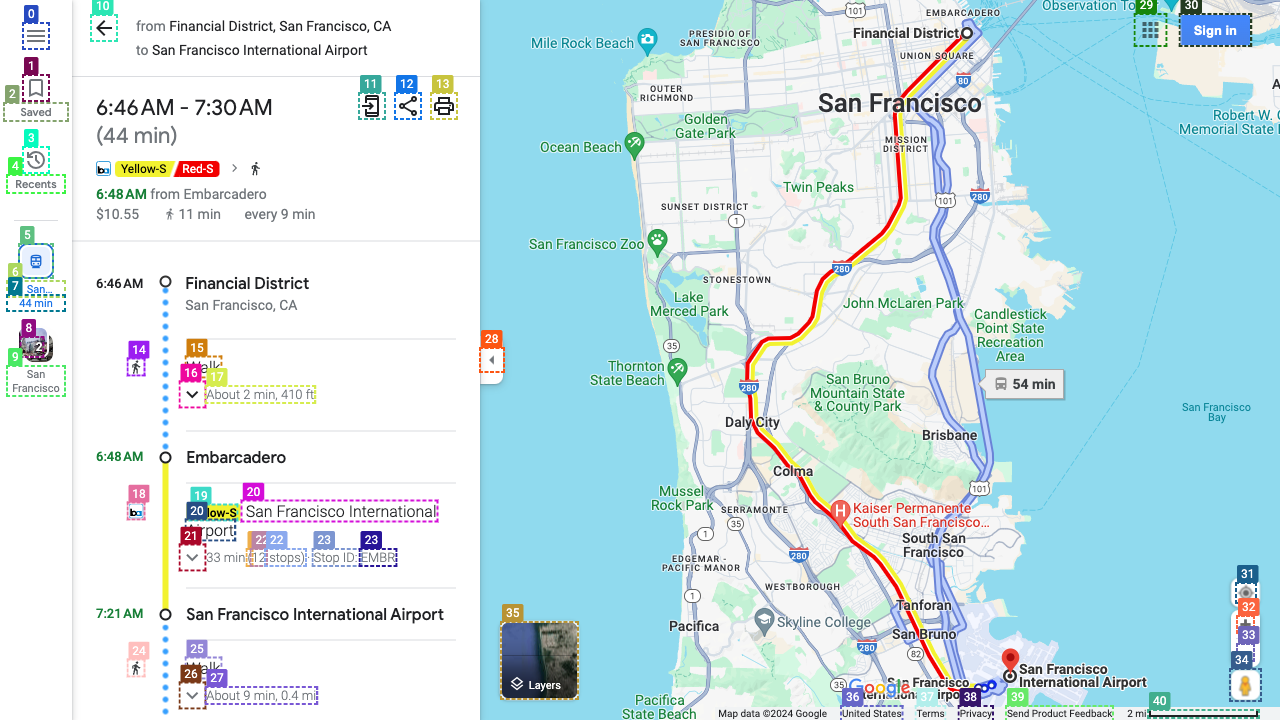

Final response: To arrive at San Francisco International Airport (SFO) by 7:00 AM starting from downtown San Francisco, you should leave by 6:46 AM according to the current Google Maps information, which estimates a 44-minute travel time.


In [16]:
res = await call_agent(
    "Could you check google maps to see when i should leave to get to SFO by 7 o'clock? starting from SF downtown.",
    page,
)
print(f"Final response: {res}")